In [37]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Dropout, Activation
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import seaborn as sns
import time

### Load data

In mysql db in my local environment but loaded using csvs for portability

In [2]:
#budget data
functions_df = pd.read_csv('../table_csvs/functions_table.csv').set_index(['District_Id','Year'])
programs_df = pd.read_csv('../table_csvs/programs_table.csv').set_index(['District_Id','Year'])
revenue_df = pd.read_csv('../table_csvs/revenue_table.csv').set_index(['District_Id','Year'])

#school data
teachers_df = pd.read_csv('../table_csvs/teachers_table.csv').set_index(['District_Id','Year'])
enrollment_df = pd.read_csv('../table_csvs/enrollment_table.csv').set_index(['District_Id','Year'])
classes_df = pd.read_csv('../table_csvs/classes_table.csv').set_index(['District_Id','Year'])

#evaluation data
test_scores_df = pd.read_csv('../table_csvs/test_scores_table.csv').set_index(['District_Id','Year'])
dropout_rates_df = pd.read_csv('../table_csvs/dropout_rates_table.csv').set_index(['District_Id','Year'])

#Uncomment one at a time to see columns and different metrics of each
# functions_df.describe().T
# programs_df.describe().T
# revenue_df.describe().T

# teachers_df.describe().T
# enrollment_df.describe().T
# classes_df.describe().T

# test_scores_df.describe().T
# dropout_rates_df.describe().T

### Preprocess Data

Create new df for function expenditure per student 

In [3]:
funct_per_student = pd.concat([functions_df, enrollment_df], axis=1)
funct_per_student = funct_per_student.div(funct_per_student['Fall_Enrollment'],axis=0).drop(['Fall_Enrollment'],axis=1)
funct_per_student.head()

Instruction_All_Funds  Instruction_General_Funds  \
District_Id Year                                                     
1902        2005            4092.806507                3783.885274   
            2006            4229.204467                3854.426117   
            2007            4644.550088                4307.441125   
            2008            7083.765517                4727.293103   
            2009            7393.742424                4988.651515   

                  Instructional_Res_Media_All_Funds  \
District_Id Year                                      
1902        2005                         103.359589   
            2006                         137.572165   
            2007                         136.209139   
            2008                         137.248276   
            2009                         142.424242   

                  Instructional_Res_Media_General_Funds  \
District_Id Year                                          
1902        2005                              81.119863   
            2006                             135.142612   
            2007                             133.720562   
            2008                              93.820690   
            2009                             101.846801   

                  Curriculum_Staff_Develop_All_Funds  \
District_Id Year                                       
1902        2005                            1.919521   
            2006                            7.309278   
            2007                            8.732865   
            2008                           29.255172   
            2009                           19.149832   

                  Curriculum_Staff_Develop_General_Funds  \
District_Id Year                                           
1902        2005                                1.077055   
            2006                                2.637457   
            2007                                1.441125   
            2008                                7.881034   
            2009                                2.149832   

                  Instructional_Leadership_All_Funds  \
District_Id Year                                       
1902        2005                            9.458904   
            2006                           27.673540   
            2007                            7.029877   
            2008                          522.131034   
            2009                          366.493266   

                  Instructional_Leadership_General_Funds  \
District_Id Year                                           
1902        2005                                     0.0   
            2006                                     0.0   
            2007                                     0.0   
            2008                                     0.0   
            2009                                     0.0   

                  School_Administration_All_Funds  \
District_Id Year                                    
1902        2005                       409.648973   
            2006                       420.606529   
            2007                       448.697715   
            2008                       445.346552   
            2009                       446.126263   

                  School_Administration_General_Funds  ...  \
District_Id Year                                       ...   
1902        2005                           407.044521  ...   
            2006                           417.919244  ...   
            2007                           448.697715  ...   
            2008                           445.346552  ...   
            2009                           446.126263  ...   

                  Plant_Maintenance_Operation_All_Funds  \
District_Id Year                                          
1902        2005                             699.385274   
            2006                             853.317869   
            2007                             950.420035 

Create new df for program expenditure per student 

In [4]:
program_per_student = pd.concat([programs_df, enrollment_df], axis=1)
program_per_student = program_per_student.div(program_per_student['Fall_Enrollment'],axis=0).drop(['Fall_Enrollment'],axis=1)
program_per_student.head()

Regular_All_Funds  Regular_General_Funds  \
District_Id Year                                             
1902        2005        3859.306507            3790.794521   
            2006        3834.027491            3762.843643   
            2007        4186.446397            4162.520211   
            2008        4480.765517            4426.168966   
            2009        4782.831650            4702.267677   

                  Gifted_Talented_All_Funds  Gifted_Talented_General_Funds  \
District_Id Year                                                             
1902        2005                  17.511986                      17.347603   
            2006                  17.798969                      17.634021   
            2007                  17.249561                      17.249561   
            2008                  17.682759                      17.682759   
            2009                  17.259259                      17.259259   

                  Career_Technology_All_Funds  \
District_Id Year                                
1902        2005                   161.032534   
            2006                   168.982818   
            2007                   201.260105   
            2008                   194.972414   
            2009                   224.781145   

                  Career_Technology_General_Funds  \
District_Id Year                                    
1902        2005                       159.804795   
            2006                       167.675258   
            2007                       201.260105   
            2008                       194.972414   
            2009                       224.781145   

                  Students_With_Disabilities_All_Funds  \
District_Id Year                                         
1902        2005                            510.321918   
            2006                            588.969072   
            2007                            630.653779   
            2008                           4636.396552   
            2009                           4313.175084   

                  Students_With_Disabilities_General_Funds  \
District_Id Year                                             
1902        2005                                502.470890   
            2006                                582.180412   
            2007                                630.653779   
            2008                                672.124138   
            2009                                633.122896   

                  Compensatory_Education_All_Funds  \
District_Id Year                                     
1902        2005                        371.265411   
            2006                        525.262887   
            2007                        551.328647   
            2008                        585.068966   
            2009                        614.392256   

                  Compensatory_Education_General_Funds  ...  \
District_Id Year                                        ...   
1902        2005                            104.974315  ...   
            2006                            193.261168  ...   
            2007                            221.335677  ...   
            2008                            310.767241  ...   
            2009                            306.365320  ...   

                  Pre_K_Regular_All_Funds  Pre_K_Regular_General_Funds  \
District_Id Year                                                         
1902        2005                      0.0                          0.0   
            2006                      0.0                          0.0   
            2007                      0.0                          0.0   
            2008                      0.0                          0.0   
            2009                      0.0                          0.0   

                  Pre_K_Bilingual_All_Funds  Pre_K_Bilingual_General_Funds  \
District_Id Year                                            

Create new df for program expenditure per student

In [5]:
revenue_per_student = pd.concat([revenue_df, enrollment_df], axis=1)
revenue_per_student = revenue_per_student.div(revenue_per_student['Fall_Enrollment'],axis=0).drop(['Fall_Enrollment'],axis=1)
revenue_per_student.head()

Total_Revenue_All_Funds  Total_Revenue_General_Funds  \
District_Id Year                                                         
1902        2005              9583.652397                  8857.416096   
            2006              8880.910653                  8057.941581   
            2007             10726.945518                  9933.328647   
            2008             16678.003448                 10166.601724   
            2009             13931.471380                  9493.080808   

                  Total_Federal_Revenue_All_Funds  \
District_Id Year                                    
1902        2005                       410.268836   
            2006                       507.532646   
            2007                       439.662566   
            2008                      3193.484483   
            2009                      2887.185185   

                  Total_Federal_Revenue_General_Funds  \
District_Id Year                                        
1902        2005                                  0.0   
            2006                                  0.0   
            2007                                  0.0   
            2008                                  0.0   
            2009                                  0.0   

                  Total_State_Revenue_All_Funds  \
District_Id Year                                  
1902        2005                    1341.828767   
            2006                    1004.886598   
            2007                    2067.281195   
            2008                    4051.950000   
            2009                    4163.927609   

                  Total_State_Revenue_General_Funds  \
District_Id Year                                      
1902        2005                        1234.905822   
            2006                         898.350515   
            2007                        1958.135325   
            2008                        3181.434483   
            2009                        3283.112795   

                  Total_Local_Revenue_All_Funds  \
District_Id Year                                  
1902        2005                    6462.398973   
            2006                    6604.077320   
            2007                    7245.258348   
            2008                    6278.191379   
            2009                    5587.818182   

                  Total_Local_Revenue_General_Funds  
District_Id Year                                     
1902        2005                        6462.398973  
            2006                        6604.077320  
            2007                        7245.258348  
            2008                        6278.191379  
            2009                        5587.818182

Combine budget data and test score data into one df
- Avg_Act has the most present values which is why it is used here
- Could have used program_per_student data here but funct_per_student provides a more general view of where money is spent

In [6]:
#Test score metric used for analysis
test_score_column = 'Avg_Act' #Other options include Avg_Sat, Above_Crit_Rate_Sat_Act, etc

#Combine into one df
dataset = pd.concat([funct_per_student, test_scores_df[test_score_column].to_frame()], axis=1).reset_index()

Clean up the data

In [7]:
dataset = dataset[dataset.Year > 2004] #No budget data for prior to 2004

#get only rows with data for all years 2005-2019
for dist in dataset.District_Id.unique():
    if len(dataset[dataset.District_Id == dist].Year.unique()) != len(range(2005,2020)):
        dataset = dataset[dataset.District_Id != dist]

#remove district with less than 60% of test scores reported
for dist in dataset.District_Id.unique():
    dist_df = dataset[dataset.District_Id == dist]
    tot_rows = dist_df.shape[0]
    act_rows = dist_df[dist_df[test_score_column].notna()].shape[0]
    if act_rows / tot_rows < .6:
        dataset = dataset[dataset.District_Id != dist]

#interpolate missing values
for dist in dataset.District_Id.unique():
    dist_df = dataset[dataset.District_Id == dist]
    dataset[dataset.District_Id == dist] = dist_df.interpolate(limit_direction='both')

Choose which funds to look at:
- General Funds are funds that districts can spend in categories they choose
- All funds include general funds but also inlcude funds that have to be used for specific purposes

In [9]:
filtered_dataset = dataset.filter(regex='(.*_General_Funds$)|(Avg_Act)|(District_Id)|(Year)')
# filtered_dataset = dataset.filter(regex='(.*_All_Funds$)|(Avg_Act)|(District_Id)|(Year)')

#remove any other features
filtered_dataset = filtered_dataset.drop(['Social_Work_Services_General_Funds','Food_General_Funds','Community_Services_General_Funds','Health_Services_General_Funds', 'Transportation_General_Funds', 'Plant_Maintenance_Operation_General_Funds'], axis=1)

filtered_dataset.head()

,District_Id,Year,Instruction_General_Funds,Instructional_Res_Media_General_Funds,Curriculum_Staff_Develop_General_Funds,Instructional_Leadership_General_Funds,School_Administration_General_Funds,Guidance_Counseling_Services_General_Funds,Cocurricular_General_Funds,General_Administration_General_Funds,Security_Monitoring_General_Funds,Data_Processing_Services_General_Funds,Total_Expenditure_By_Function_General_Funds,Avg_Act
4,1902,2005,3783.885274,81.119863,1.077055,0.0,407.044521,227.037671,299.875000,466.000000,2.873288,112.255137,6448.922945,19.2
5,1902,2006,3854.426117,135.142612,2.637457,0.0,417.919244,230.134021,302.065292,488.630584,4.790378,114.761168,6777.001718,19.5
6,1902,2007,4307.441125,133.720562,1.441125,0.0,448.697715,246.123023,327.903339,527.416520,3.263620,136.427065,7495.776801,19.8
7,1902,2008,4727.293103,93.820690,7.881034,0.0,445.346552,254.143103,378.896552,534.712069,2.643103,157.198276,8023.825862,19.1
8,1902,2009,4988.651515,101.846801,2.149832,0.0,446.126263,252.594276,452.668350,435.112795,1.464646,157.636364,8302.456229,18.4


Break dataset into windows so we can attempt to predict the next years test score based on previous results and budget data features

In [18]:
def split_windows(df, window_size=4):
    inputs = np.empty((0, window_size, len(df.columns)))
    labels = np.array([])
    
    for i in range(len(df.Year.unique()) - window_size + 1):
        start_year = 2005
        
        window_df = df.loc[df.Year >= start_year + i].loc[df.Year < start_year + i + window_size]
        ids = len(window_df.District_Id.unique())
        window_array = np.array(window_df)
        
        window_inputs = np.array(np.array_split(window_array, ids))
        window_labels = window_inputs[:,-1,-1].copy()
        window_inputs[:,-1,-1] = 1
        
        inputs = np.concatenate((inputs, window_inputs),axis=0)
        
        labels = np.append(labels,[window_labels])
    
    return inputs, labels

label_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_labels = label_scaler.fit_transform(np.array(filtered_dataset)[:,-1].reshape(-1,1))

feature_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = feature_scaler.fit_transform(np.array(filtered_dataset)[:,2:-1])

scaled_dataset = pd.DataFrame(np.hstack((np.array(filtered_dataset)[:,:2], scaled_features, scaled_labels)), columns=filtered_dataset.columns)

window = 8
inputs, labels = split_windows(scaled_dataset, window)

### Build the Model

Split train and test data

In [19]:
splits = (np.array([.6,1]) * inputs.shape[0]).astype(int) 

train_inputs = inputs[:splits[0],:,:]
test_inputs = inputs[splits[0]:splits[1],:,:]

train_labels = labels[:splits[0]]
test_labels = labels[splits[0]:splits[1]]

#Remove year and district id
train_inputs = train_inputs[:,:,2:]
test_inputs = test_inputs[:,:,2:]

features = train_inputs.shape[2]

# train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels)).shuffle(buffer_size=1024).batch(32)
# test_dataset = tf.data.Dataset.from_tensor_slices((test_inputs, test_labels)).shuffle(buffer_size=1024).batch(32)

Create model architecture

In [35]:
EPOCHS = 10
BATCH_SIZE = 32

def create_model(window, features):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(units = 64, return_sequences = True, input_shape = (window, features)))
    model.add(Dropout(0.2))

#     model.add(tf.keras.layers.LSTM(units = 64, return_sequences = True, input_shape = (window, features)))
#     model.add(Dropout(0.2))
    
#     model.add(tf.keras.layers.LSTM(units = 64, return_sequences = True, input_shape = (window, features)))
#     model.add(Dropout(0.2))

#     model.add(tf.keras.layers.LSTM(units = 64, return_sequences = True, input_shape = (window, features)))
#     model.add(Dropout(0.2))

    model.add(tf.keras.layers.LSTM(units = 80, return_sequences = False))
    model.add(Dropout(0.2))

    model.add(Dense(units = 1))
    
    model.compile(optimizer = tf.optimizers.Adam(), loss = tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError()])
    
    return model

def fit_predict(model, train_data, train_labels, test_data, test_labels):
    model.fit(train_data, train_labels, epochs = EPOCHS, batch_size=BATCH_SIZE)
    
    predictions = model.predict(test_data)
    predictions = label_scaler.inverse_transform(predictions)

    actual = label_scaler.inverse_transform(test_labels.reshape(1,-1))

    comp = pd.DataFrame(np.hstack((actual.T, predictions)),columns=['actual','predicted'])
    high = np.array(comp[comp['actual'] > 25])
    low = np.array(comp[comp['actual'] < 15])
    mid = np.array(comp[comp['actual'] >= 15][comp['actual'] <= 25])
    tot = np.array(comp)

    print("Total MSE: ", np.sqrt(np.mean((tot[:,0] - tot[:,1])**2)))
    print("High MSE: ", np.sqrt(np.mean((high[:,0] - high[:,1])**2)))
    print("Low MSE: ", np.sqrt(np.mean((low[:,0] - low[:,1])**2)))
    print("Mid MSE: ", np.sqrt(np.mean((mid[:,0] - mid[:,1])**2)))

    print(comp.head(5))    
    print(comp[comp['actual'] > 25].head(5))
    print(comp[comp['actual'] < 15].head(5))

Train and test model

In [36]:
real_model = create_model(window,features)

fit_predict(real_model, train_inputs, train_labels, test_inputs, test_labels)

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
140/140 [==============================] - 1s 9ms/step - loss: 0.0135 - mean_absolute_error: 0.0814
Epoch 2/10
140/140 [==============================] - 1s 9ms/step - loss: 0.0049 - mean_absolute_error: 0.0531
Epoch 3/10
140/140 [==============================] - 1s 9ms/step - loss: 0.0049 - mean_absolute_error: 0.0531
Epoch 4/10
140/140 [==============================] - 1

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Run model with garbage data to compare with

In [22]:
garbage_model = create_model(window,features)

rand_data = np.random.rand(train_inputs.shape[0],train_inputs.shape[1],train_inputs.shape[2])
fit_predict(garbage_model, rand_data, train_labels, test_inputs, test_labels)

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
140/140 [==============================] - 3s 18ms/step - loss: 0.0170 - mean_absolute_error: 0.0990
Epoch 2/10
140/140 [==============================] - 2s 16ms/step - loss: 0.0112 - mean_absolute_error: 0.0836
Epoch 3/10
140/140 [==============================] - 2s 17ms/step - loss: 0.0112 - mean_absolute_error: 0.0834
Epoch 4/10
140/140 [==============================] 

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


### Data Visualizations

Test score by total amount spent on functions

<AxesSubplot:xlabel='Total_Expenditure_By_Function_General_Funds', ylabel='Avg_Act'>

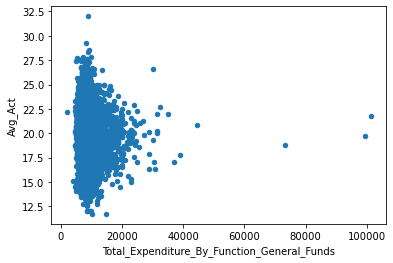

In [34]:
dataset[['Avg_Act','Total_Expenditure_By_Function_General_Funds']].plot.scatter(x='Total_Expenditure_By_Function_General_Funds',y=test_score_column)


Test score by amount spent on teachers

<AxesSubplot:xlabel='Instruction_General_Funds', ylabel='Avg_Act'>

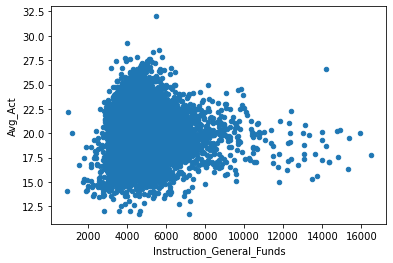

In [35]:
dataset[['Avg_Act','Instruction_General_Funds']].plot.scatter(x='Instruction_General_Funds',y='Avg_Act')

Test score by amount spent on security

<AxesSubplot:xlabel='Security_Monitoring_General_Funds', ylabel='Avg_Act'>

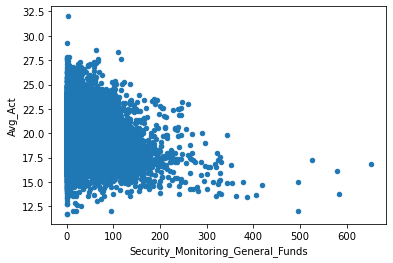

In [36]:
dataset[['Avg_Act','Security_Monitoring_General_Funds']].plot.scatter(x='Security_Monitoring_General_Funds',y='Avg_Act')